In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\GUIDE_Train.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1786,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,1492,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,2573,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,4528,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,3722,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [3]:
# shape of the dataset
df.shape

(9516837, 45)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int32   
 1   OrgId               int32   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int32   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [5]:
# Check for missing values
df.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [6]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count

22576

In [7]:
# Target variable distribution
df['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

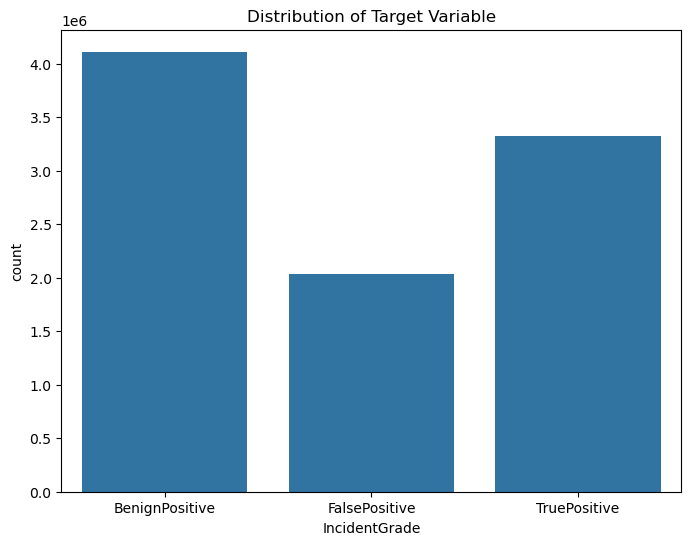

In [8]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [29]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

In [11]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [12]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5)

In [23]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [24]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [25]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [26]:
import os

# Correct file path
path = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv"

# Ensure the directory exists
directory = os.path.dirname(path)
if not os.path.exists(directory):
    os.makedirs(directory)  # Create the directory if it doesn't exist

# Save the DataFrame
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Data preprocessing complete and saved.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df_1):
    # Downcast numerical columns
    for col in df_1.columns:
        col_type = df_1[col].dtypes
        if col_type == 'int64':
            df_1[col] = df_1[col].astype('int32')
        elif col_type == 'float64':
            df_1[col] = df_1[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df_1[col] = df_1[col].astype('category')
    return df_1

chunks = []
test_dataset = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df_1 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

df_1.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Year,Month,DayOfWeek,Hour
0,3028,75,478,939479,4,0.006834,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.608696
1,1813,0,211,160158,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.166667,0.347826
2,1455,88,26726,1114326,58,0.097950,4,1,6,0,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.043478
3,1731,0,375,169963,0,0.000000,5,2,0,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.000000,0.217391
4,4097,108,144844,118616,6,0.011390,5,2,5,1,...,3586,5,66,242,1445,10630,1.0,0.454545,0.500000,0.652174



Shape of the dataset: (760627, 38)
Column Names in the Dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760627 entries, 0 to 760626
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  760627 non-null  int32  
 1   OrgId               760627 non-null  int32  
 2  

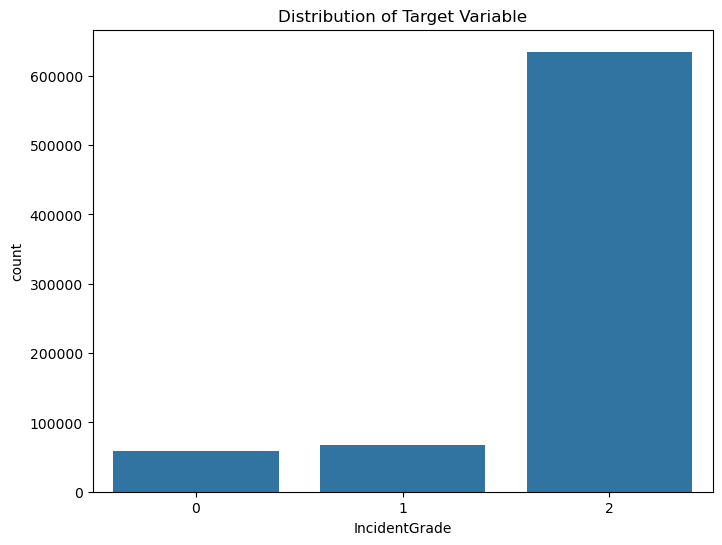

In [22]:
# Shape of the dataset
print("\nShape of the dataset:", df_1.shape)

# Column names
print("Column Names in the Dataset:")
print(df_1.columns)

print("\nDataset Information:")
print(df_1.info())

# Check for missing values
print("\nMissing values:")
print(df_1.isnull().sum())

# Check for duplicate rows
duplicate_count = df_1.duplicated().sum()
print("\nNumber of duplicate rows in the dataset:", duplicate_count)

# Target variable distribution
print("\nTarget variable distribution:")
print(df_1['IncidentGrade'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=df_1['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [33]:
print(df_1.columns)

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'DayOfWeek', 'Hour'],
      dtype='object')


In [34]:
if 'Timestamp' in df_1.columns:
    # Convert 'Timestamp' to datetime and extract features
    df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
    df_1['Year'] = df_1['Timestamp'].dt.year
    df_1['Month'] = df_1['Timestamp'].dt.month
    df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
    df_1['Hour'] = df_1['Timestamp'].dt.hour
    
    # Drop the 'Timestamp' column after extracting features
    df_1.drop(columns=['Timestamp'], inplace=True)
else:
    print("The column 'Timestamp' does not exist in the dataset.")

The column 'Timestamp' does not exist in the dataset.


In [35]:
columns_to_drop = missing_percentage[missing_percentage > 50].index
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

In [36]:
columns_to_drop = missing_percentage[missing_percentage > 50].index
columns_to_drop = [col for col in columns_to_drop if col != 'Timestamp']
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

In [37]:
# Feature Engineering: Extracting datetime features
if 'Timestamp' in df_1.columns:
    df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
    df_1['Year'] = df_1['Timestamp'].dt.year
    df_1['Month'] = df_1['Timestamp'].dt.month
    df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
    df_1['Hour'] = df_1['Timestamp'].dt.hour
    
    # Drop the 'Timestamp' column
    df_1.drop(columns=['Timestamp'], inplace=True)
else:
    print("The column 'Timestamp' does not exist in the dataset.")

The column 'Timestamp' does not exist in the dataset.


In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Calculate the percentage of missing values for each column
missing_percentage = df_1.isnull().sum() / len(df_1) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped:")
print(columns_to_drop)

# Drop these columns
df_1.drop(columns=columns_to_drop, axis=1, inplace=True)

# Impute missing values for numeric columns
numeric_columns = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64']).columns
for col in numeric_columns:
    if df_1[col].isnull().any():
        median_val = df_1[col].median()
        df_1[col] = df_1[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

# Impute missing values for categorical columns
categorical_columns = df_1.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if df_1[col].isnull().any():
        mode_val = df_1[col].mode()[0]
        df_1[col] = df_1[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

# Handling Outliers
def handle_outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers
df_1 = handle_outliers(df_1, iqr_multiplier=1.5)

# Feature Engineering: Extracting datetime features
df_1['Timestamp'] = pd.to_datetime(df_1['Timestamp'], errors='coerce')
df_1['Year'] = df_1['Timestamp'].dt.year
df_1['Month'] = df_1['Timestamp'].dt.month
df_1['DayOfWeek'] = df_1['Timestamp'].dt.dayofweek
df_1['Hour'] = df_1['Timestamp'].dt.hour

# Drop the 'Timestamp' and 'Usage' column
df_1.drop(columns=['Timestamp', 'Usage'], inplace=True, errors='ignore')

# List of ID columns to exclude from scaling
id_columns = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256',
    'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
    'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
    'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
    'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion',
    'City', 'CountryCode', 'State'
]

# Exclude ID columns from scaling
numeric_features = df_1.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features
scaler = MinMaxScaler()
df_1[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Encoding categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df_1.columns:
        df_1[col] = label_encoder.fit_transform(df_1[col].astype(str))  # Convert to string if necessary

# Remove duplicate rows
df_1.drop_duplicates(inplace=True)

# Save the processed dataset
path = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv"
df_1.to_csv(path, index=False)
print("Data preprocessing complete and saved.")

Columns with more than 50% missing values are dropped:
Index([], dtype='object')


KeyError: 'Timestamp'

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load the dataset     
df = pd.read_csv(r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize logistic regression
logreg = LogisticRegression(C = 100, penalty = 'l1', solver='liblinear')

logreg = logreg.fit(X_train,y_train)

# Evaluate the model on validation data
y_pred = logreg.predict(X_val)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65     11720
           1       0.81      0.57      0.67     13464
           2       0.94      0.97      0.96    126942

    accuracy                           0.91    152126
   macro avg       0.80      0.73      0.76    152126
weighted avg       0.91      0.91      0.91    152126

Confusion Matrix:
[[  7723   1121   2876]
 [  1387   7664   4413]
 [  3085    684 123173]]


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint

# Load the dataset
df = pd.read_csv(r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth= 20, min_samples_split=4, min_samples_leaf=1, 
                               max_features= 'log2', random_state=42)

# Evaluate the model on validation data
dtree = dtree.fit(X_train,y_train)

y_pred = dtree.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     11720
           1       0.92      0.92      0.92     13464
           2       0.99      0.99      0.99    126942

    accuracy                           0.98    152126
   macro avg       0.92      0.94      0.93    152126
weighted avg       0.98      0.98      0.98    152126

Confusion Matrix:
[[ 10596    576    548]
 [   639  12454    371]
 [  1142    512 125288]]


In [41]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

rf = rf.fit(X_train,y_train)
# Evaluate the best model on validation data
y_pred = rf.predict(X_val)

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11720
           1       0.97      0.98      0.97     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.98      0.98      0.98    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11440    209     71]
 [   175  13142    147]
 [    99    167 126676]]


In [42]:
! pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 325.1 kB/s eta 0:06:25
   ---------------------------------------- 0.1/124.9 MB 465.5 kB/s eta 0:04:29
   ---------------------------------------- 0.1/124.9 MB 798.9 kB/s eta 0:02:37
   ---------------------------------------- 0.2/124.9 MB 980.4 kB/s eta 0:02:08
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:52
   ---------------------------------------- 0.4/124.9 MB 1.4 MB/s eta 0:01:28
   ---------------------------------------- 0.7/124.9 MB 2.0 MB/s eta 0:01:03
   ---------------------------------------- 1.0/124.9 MB 2.5 MB/s eta 0:00:51
   ---------------------------------------- 1.3/124.9 MB 3.0 MB/s eta 0:00:42
    --------------------------------------- 1.6/124.9 MB 3.4 MB/s eta 0:00:37
    --------------------------------------- 2.0/124.9 MB 3.6 MB/s eta 

In [43]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Load dataset
df = pd.read_csv(r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb = xgb.XGBClassifier(subsample = 0.8, n_estimators = 200, max_depth = 9, learning_rate = 0.2, colsample_bytree = 1.0,
                        random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb = xgb.fit(X_train,y_train)
# Evaluate the model on validation data
y_pred = xgb.predict(X_val)

# Print the evaluation results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

C:\Users\Admin\anaconda3.s\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11720
           1       0.97      0.97      0.97     13464
           2       1.00      1.00      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.98      0.98      0.98    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11410    238     72]
 [   186  13110    168]
 [   148    183 126611]]


In [44]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.98,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.93, 0.98, 0.98],
    'Precision': [0.80,0.92,0.98,0.98],
    'Recall': [0.73,0.94,0.98 ,0.98]

}

# Convert to DataFrame
df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = df.loc[df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.98            0.93       0.92    0.94
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.98       0.98    0.98

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


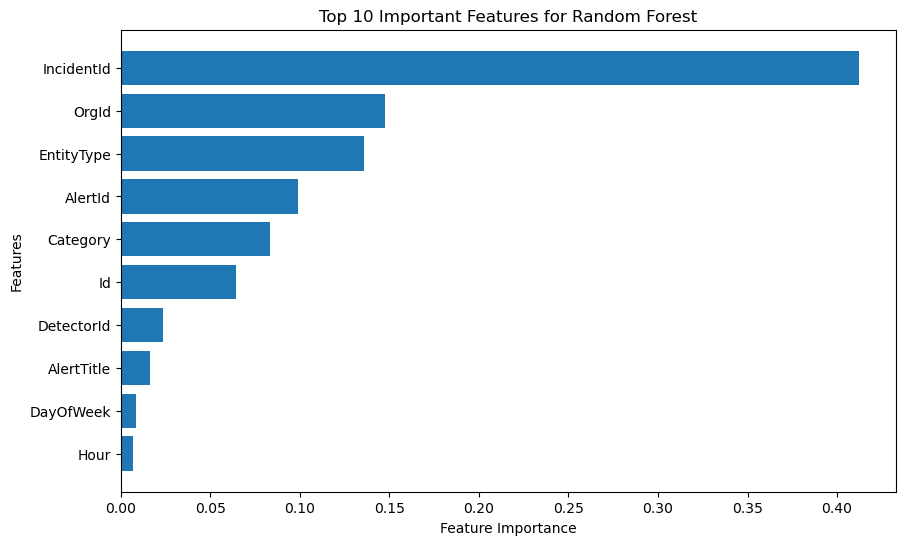

          Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  Category  \
396217  3878    239       89766  1233895           7    0.013667         5   
385613  1109     56      127937   119184           6    0.011390         5   
416218   779    350       35994   239468           1    0.002278         5   
168089  3167     33       37760   303741           6    0.011390         5   
114816   508     77      151611   523501           0    0.000000         5   

        EntityType  EvidenceRole  DeviceId  ...  ResourceIdName  OSFamily  \
396217           0             1     98799  ...            3586         5   
385613           5             1     98799  ...            3586         5   
416218           5             1     98799  ...            3586         5   
168089           5             1     98799  ...            3586         5   
114816           0             1     98799  ...            3586         5   

        OSVersion  CountryCode  State   City  Year     Month  DayOfW

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from imblearn.pipeline import Pipeline
from scipy.stats import randint

# Load dataset
df = pd.read_csv(r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv")

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)

# Initialize Random Forest Classifier 
rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = None, max_depth = 30, 
                            bootstrap = True, random_state=42)

# Create the Pipeline
pipeline = Pipeline(steps=[
    ('smote', smote),
    ('classifier', rf)
])

# Fit the Pipeline
pipeline.fit(X_train, y_train)

# Evaluate the best model on validation data
y_pred = pipeline.predict(X_val)

# Print results
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save the best model to a pickle file
model_path = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Untitled Folder\Model.pkl"
dump(rf, model_path)
print(f"Model saved to {model_path}")

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11720
           1       0.96      0.97      0.97     13464
           2       1.00      0.99      1.00    126942

    accuracy                           0.99    152126
   macro avg       0.97      0.98      0.97    152126
weighted avg       0.99      0.99      0.99    152126

Confusion Matrix:
[[ 11399    274     47]
 [   264  13085    115]
 [   454    273 126215]]
Model saved to C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Untitled Folder\Model.pkl


In [49]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Load the saved Random Forest model
model_path = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Untitled Folder\Model.pkl"
best_rf = load(model_path)

# Load the test dataset
test_data_path = r"C:\Users\Admin\Downloads\GUIDE_Train.csv\Cleaned_dataset\Train_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Separate features and target from test data
X_test = test_df.drop('IncidentGrade', axis=1)  
y_test = test_df['IncidentGrade']

# Make predictions on the test set
y_test_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Extract macro-F1 score, precision, and recall from the report
macro_f1 = report['macro avg']['f1-score']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']

print("\nMacro-F1 Score: {:.2f}".format(macro_f1))
print("Macro Precision: {:.2f}".format(macro_precision))
print("Macro Recall: {:.2f}".format(macro_recall))

# Confusion Matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     58601
           1       0.99      0.99      0.99     67320
           2       1.00      1.00      1.00    634706

    accuracy                           1.00    760627
   macro avg       0.99      1.00      0.99    760627
weighted avg       1.00      1.00      1.00    760627


Macro-F1 Score: 0.99
Macro Precision: 0.99
Macro Recall: 1.00

Confusion Matrix on Test Data:
[[ 58280    274     47]
 [   275  66930    115]
 [   566    295 633845]]
